In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import data
kd = data.Kaya_data

估计CG

In [27]:
# 已知数据
GDP = kd["GDP"]
MTCO2e = kd["MTCO2e"]

# 计算总体CI (排除无效数据)
CI_values = [mtco2e / gdp for gdp, mtco2e in zip(GDP, MTCO2e) if gdp != -1 and mtco2e != -1]

# 计算均值和标准差
mean_CI = np.mean(CI_values)
std_CI = np.std(CI_values, ddof=1)  # 使用样本标准差

# 计算95%的置信区间
n = len(CI_values)
alpha = 0.05  # 95%置信区间
t_score = stats.t.ppf(1 - alpha / 2, df=n - 1)  # t分布临界值
margin_of_error = t_score * (std_CI / np.sqrt(n))

# 置信区间
CI_lower = mean_CI - margin_of_error
CI_upper = mean_CI + margin_of_error

mean_CI, CI_lower, CI_upper

(0.17768003326499263, 0.17022531662734983, 0.18513474990263543)

In [28]:
# 经验公式算出每年的旅游收入
tourism_income = kd["Tourism_Numbers"]
tourism_income = [i * 632 for i in tourism_income]
# print(tourism_income)

预测ratio

10 10
[85.91571513734122, 92.77766410401226, 106.28607924622482, 119.28443910512954, 116.49192786644336, 119.15962976785639, 57.53798190344494, 101.21215240227299, 112.87600266984957, 106.88908469682596]


c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

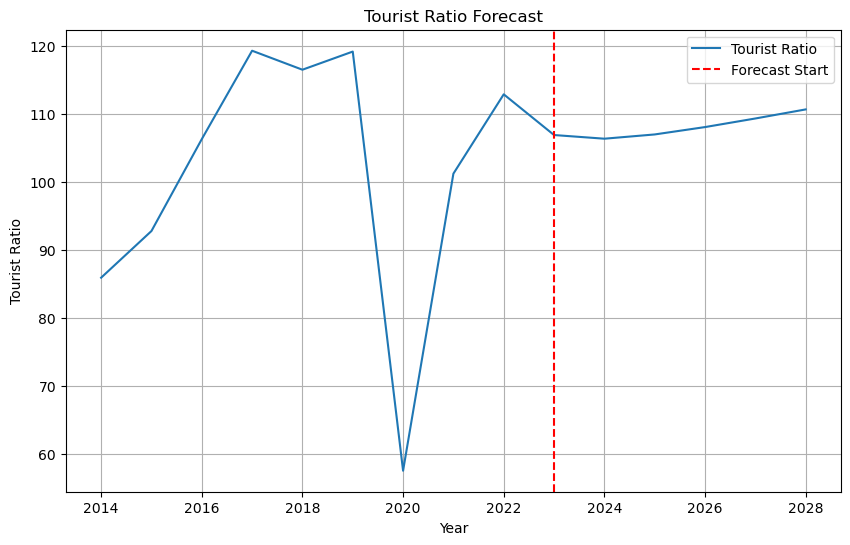

In [33]:
# # 旅游收入占GDP的比例
# tourism_income_ratio = [i / j for i, j in zip(tourism_income, GDP) if j != -1]
# print(tourism_income_ratio)

# # 线性预测后面的比例
# X = np.arange(2014, 2024).reshape(-1, 1)
# y = np.array(tourism_income_ratio).reshape(-1, 1)
# assert len(X) == len(y)

# lr_model = LinearRegression()
# lr_model.fit(X, y)

# X = np.arange(2014, 2029).reshape(-1, 1)
# tourism_income_ratio_pred = lr_model.predict(X)

# # 旅游收入预测
# # 画图
# plt.figure(figsize=(10, 6))
# plt.plot(X, tourism_income_ratio_pred, label="Tourism Income Ratio Prediction")
# plt.plot(np.arange(2014, 2024), tourism_income_ratio, label="Tourism Income Ratio")
# plt.legend()
# plt.xlabel("Year")
# plt.ylabel("Tourism Income Ratio")
# plt.title("Tourism Income Ratio Prediction")
# plt.show()

# # # SARIMA模型预测
# data = {
#     "Year": [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
#     "GDP": [2524869000, 2435418000, 2437578000, 2511152000, 2467392000, 2414435000, 2292657000, 2421944000, 2423728000, 2387533000],
#     "Tourism_Numbers": [9.61e5, 9.83e5, 1.015e6, 1.072e6, 1.151e6, 1.306e6, 1.259667e6, 1.213333e6, 1.167e6, 1.67e6],
#     "GDP": [2524869000, 2435418000, 2437578000, 2511152000, 2467392000, 2414435000, 2292657000, 2421944000, 2423728000, 2387533000]
# }
data = {
    "Year": [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    "GDP": [523368, 520554, 484813, 479694, 511699, 523008, 473690, 564108, 612414, 677909],
    "MTCO2e": [90000, 90000, 90000, 90000, 90000, 90000, -1, -1, -1, -1],
    "Tourism_Numbers": [71148, 74919, 78367, 85316, 87135, 89314, 38294, 78646, 93353, 95937],
}

tourism_number = data["Tourism_Numbers"]
# 人均旅游以2%的增长率增长，初始为632
tourism_spend = [632 * (1 + 0.02) ** i for i in range(20)]
tmp = tourism_spend[0:10]
print(len(tourism_number), len(tmp))

assert len(tourism_number) == len(tmp)
tourism_income = [i * j for i, j in zip(tourism_number, tmp)]
GDP = data["GDP"]

tourism_income_ratio = [i / j for i, j in zip(tourism_income, GDP) if j != -1]

print(tourism_income_ratio)


df = pd.DataFrame(data)
df.set_index('Year', inplace=True)
df["Pande_Impact"] = [0, 0, 0, 0, 0, 0, 0.2, 1, 0.8, 0]
df["Tourist_Ratio"] = tourism_income_ratio

# 扩展预测年份到2030年
forecast_years = list(range(2024, 2029))
forecast_exog = np.zeros(len(forecast_years))  # 假设未来几年疫情影响因子为0

model0 = SARIMAX(df["Tourist_Ratio"], exog=df['Pande_Impact'], order=(1, 2, 2))
fitted_model0 = model0.fit()

forecast0 = fitted_model0.forecast(steps=len(forecast_years), exog=forecast_exog)

forecast_df0 = pd.DataFrame({

    'Year': forecast_years,
    'Tourist_Ratio': forecast0
})

forecast_df0.set_index('Year', inplace=True)

combined_df0 = pd.concat([df, forecast_df0])
plt.figure(figsize=(10, 6))

plt.plot(combined_df0.index, combined_df0['Tourist_Ratio'], label='Tourist Ratio')
plt.axvline(x=2023, color='r', linestyle='--', label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Tourist Ratio')
plt.title('Tourist Ratio Forecast')
plt.legend()
plt.grid(True)
plt.show()

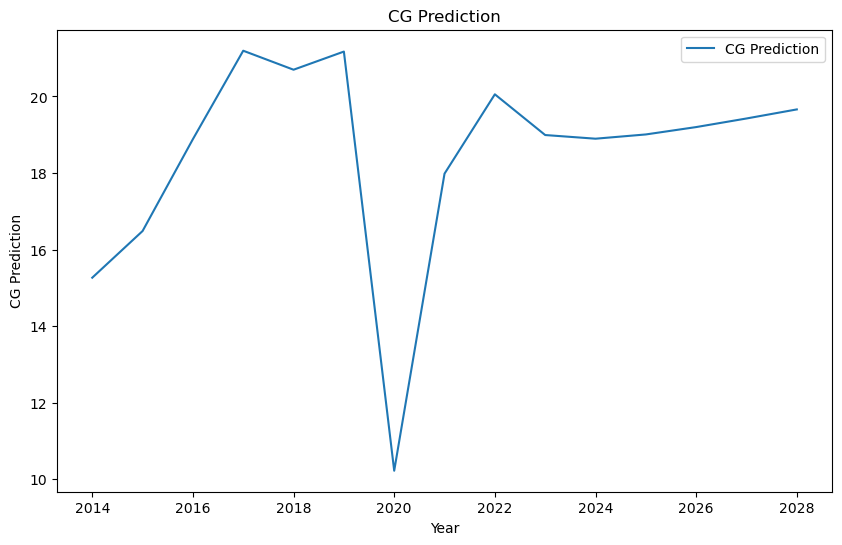

In [34]:
# 预测旅游的CI：用总的CI乘以预测的旅游收入比例
CI_pred = [mean_CI * i for i in combined_df0['Tourist_Ratio']]

CI_pred = [float(ci) for ci in CI_pred]
CI_pred

# 画图
plt.figure(figsize=(10, 6))
plt.plot(combined_df0.index, CI_pred, label="CG Prediction")
plt.xlabel("Year")
plt.ylabel("CG Prediction")
plt.title("CG Prediction")
plt.legend()
plt.show()


探究CI和旅游人数的关系

(15, 1) (15, 1)
方程：
CI =  [[4.03770723e-05]] * n +  [14.54012436]
相关系数：
0.2673785725980574


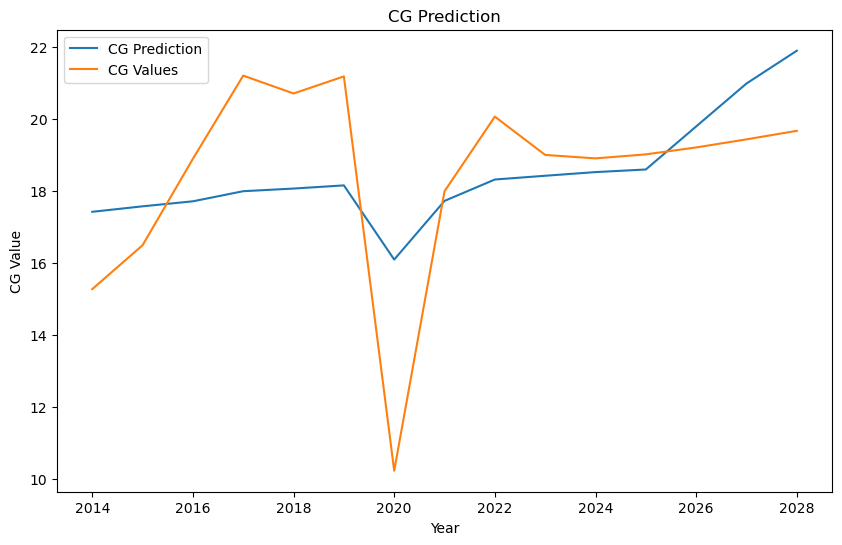

In [35]:
X = np.array(kd["Tourism_Numbers"]).reshape(-1, 1)
y = np.array(CI_pred).reshape(-1, 1)

print(X.shape, y.shape)
assert X.shape == y.shape

model_CI_num = LinearRegression()
model_CI_num.fit(X, y)

# 方程
print("方程：")
print("CI = ", model_CI_num.coef_, "* n + ", model_CI_num.intercept_)

# 相关系数
print("相关系数：")
r = model_CI_num.score(X, y)
print(r)

# 预测并画图
y_pred = model_CI_num.predict(X)

plt.figure(figsize=(10, 6))
plt.plot(kd["Year"], y_pred, label="CG Prediction")
plt.plot(kd["Year"], CI_pred, label="CG Values")
plt.xlabel("Year")
plt.ylabel("CG Value")
plt.title("CG Prediction")
plt.legend()
plt.show()

预测GDP

c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


               GDP   MTCO2e  Tourism_Numbers  Pande_Impact  Tourist_Ratio
Year                                                                     
2014  5.233680e+05  90000.0          71148.0           0.0      85.915715
2015  5.205540e+05  90000.0          74919.0           0.0      92.777664
2016  4.848130e+05  90000.0          78367.0           0.0     106.286079
2017  4.796940e+05  90000.0          85316.0           0.0     119.284439
2018  5.116990e+05  90000.0          87135.0           0.0     116.491928
2019  5.230080e+05  90000.0          89314.0           0.0     119.159630
2020  4.736900e+05     -1.0          38294.0           0.2      57.537982
2021  5.641080e+05     -1.0          78646.0           1.0     101.212152
2022  6.124140e+05     -1.0          93353.0           0.8     112.876003
2023  6.779090e+05     -1.0          95937.0           0.0     106.889085
2024  7.709310e+05      NaN              NaN           NaN            NaN
2025  8.459275e+05      NaN           

c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


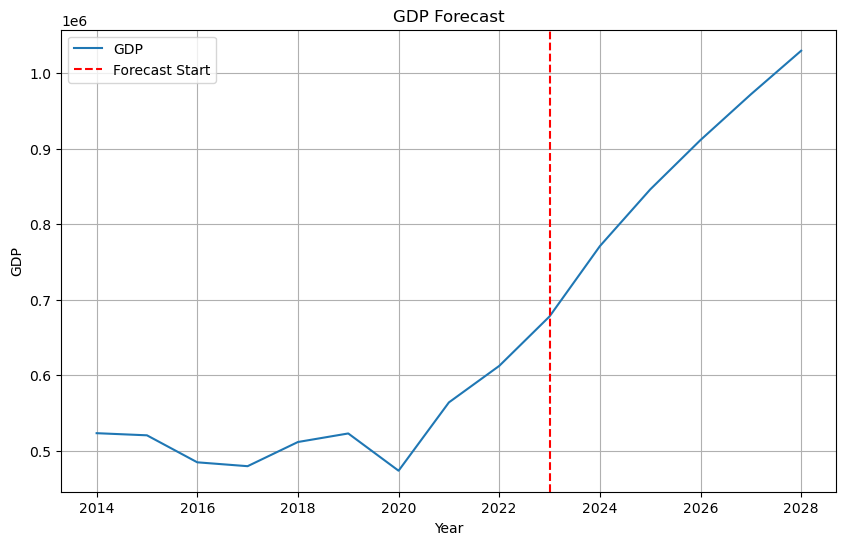

In [36]:
model = SARIMAX(df['GDP'], exog=df['Pande_Impact'], order=(1, 2, 2))
fitted_model = model.fit()



forecast = fitted_model.forecast(steps=len(forecast_years), exog=forecast_exog)

forecast_df = pd.DataFrame({
    'Year': forecast_years,
    'GDP': forecast
})
forecast_df.set_index('Year', inplace=True)

# 合并已知数据和预测数据
combined_df = pd.concat([df, forecast_df])

print(combined_df)

combined_df.to_csv('combined_df.csv')

# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(combined_df.index, combined_df['GDP'], label='GDP')
plt.axvline(x=2023, color='r', linestyle='--', label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('GDP Forecast')
plt.legend()
plt.grid(True)
plt.show()

kaya公式

[686421710.1239715, 796143369.8375139, 973118338.894133, 1212747809.206753, 1233800268.245673, 1319487405.2460952, 278639122.62898326, 1026753536.0022365, 1386394987.1382468, 1376184756.1053972, 1433305196.3955064, 1497306579.4036956, 1998208222.8997679, 2530945619.7037716, 2982780592.8620653]


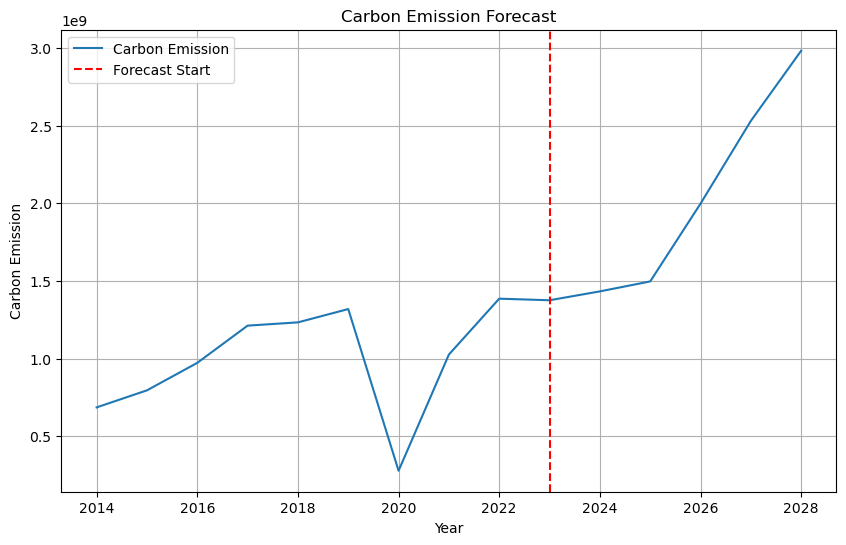

In [37]:
"""
碳排放量 = 旅游人数n * 旅游消费 * CI
        = 旅游人数n * 旅游消费 * model_CI_num(旅游人数n)
        = 旅游人数n * 旅游消费 * ([5.58710278e-07] * n +  [0.0210651])
        
"""

C_tourism = [i * j * k for i, j, k in zip(kd["Tourism_Numbers"], tourism_spend, CI_pred)]
print(C_tourism)

# 绘制图像

plt.figure(figsize=(10, 6))
plt.plot(range(2014, 2029), C_tourism, label='Carbon Emission')
plt.axvline(x=2023, color='r', linestyle='--', label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Carbon Emission')
plt.title('Carbon Emission Forecast')
plt.legend()
plt.grid(True)
plt.show()


碳排放定价

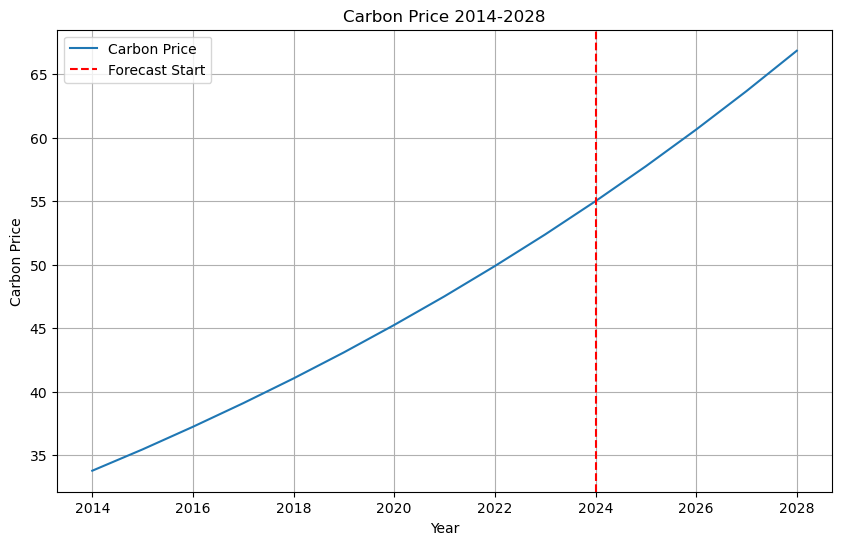

In [38]:
# 2024是55/吨， 25年开始按5%递增
C_price = [33.77, 35.45, 37.23, 39.09, 41.04, 43.09, 45.25, 47.51, 49.89, 52.38, 55, 57.75, 60.64, 63.67, 66.85]

# 画图
plt.figure(figsize=(10, 6))
plt.plot(range(2014, 2029), C_price, label='Carbon Price')
plt.axvline(x=2024, color='r', linestyle='--', label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Carbon Price')
plt.title('Carbon Price 2014-2028')
plt.legend()
plt.grid(True)
plt.show()

碳代价 = 碳排放量 * 碳排放定价

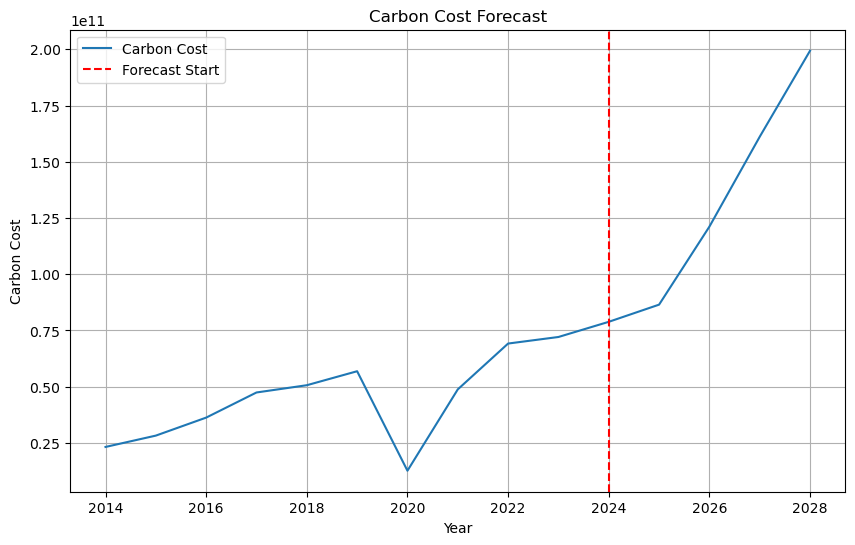

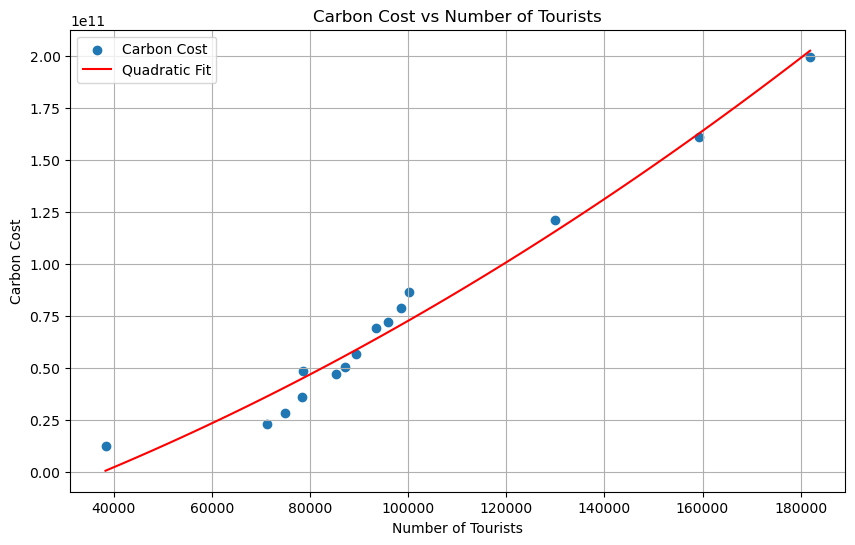

二次多项式系数：
[ 2.89699425e+00  7.67038532e+05 -3.29277447e+10]


In [45]:
C_cost = [i * j for i, j in zip(C_tourism, C_price)]

# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(range(2014, 2029), C_cost, label='Carbon Cost')
plt.axvline(x=2024, color='r', linestyle='--', label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Carbon Cost')
plt.title('Carbon Cost Forecast')
plt.legend()
plt.grid(True)
plt.show()


# 用二次多项式拟合
coefficients = np.polyfit(tourism, C_cost, 2)
poly = np.poly1d(coefficients)

# 生成拟合曲线
tourism_fit = np.linspace(min(tourism), max(tourism), 100)
C_cost_fit = poly(tourism_fit)

# 绘制图像
plt.figure(figsize=(10, 6))
plt.scatter(tourism, C_cost, label='Carbon Cost')
plt.plot(tourism_fit, C_cost_fit, color='red', label='Quadratic Fit')
plt.xlabel('Number of Tourists')
plt.ylabel('Carbon Cost')
plt.title('Carbon Cost vs Number of Tourists')
plt.legend()
plt.grid(True)
plt.show()

# 输出系数
print("二次多项式系数：")
print(coefficients)


碳代价与旅游人口的关系

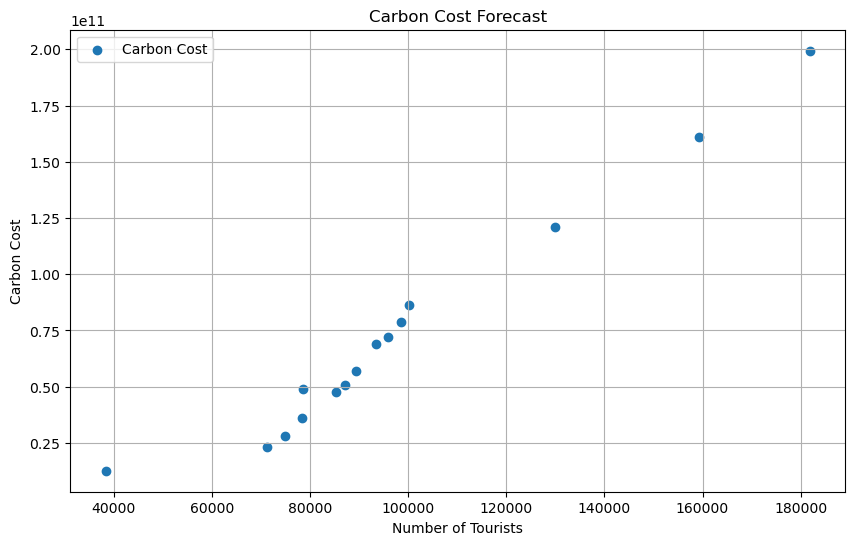

In [40]:
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c
# 绘制图像
tourism = kd["Tourism_Numbers"]

plt.figure(figsize=(10, 6))
plt.scatter(tourism, C_cost, label='Carbon Cost')

plt.xlabel('Number of Tourists')
plt.ylabel('Carbon Cost')
plt.title('Carbon Cost Forecast')
plt.legend()
plt.grid(True)
plt.show()